# Guidelines: Training Surrogate Models of Nanoelectronic Devices
**By Hans-Christian Ruiz Euler**  

This report serves as a guide to training surrogate models of nanoelectronic devices based on the experiences obtained for dopant network processing units (DNPUs). In addition, the importance of the batch size and learning rate in training DNPUs is discussed. 
DNPUs are nanoelectronic devices composed of *n* activation electrodes and *m* output terminals. DNPUs have a complex, nonlinear voltage-to-current relation that can be used to solve classification tasks. This is done by choosing a subset of the *n* activation electrodes as "data input" electrodes and the remaining subset as "control electrodes" that must be set to specific "control voltage" configurations to give the desired solution for the task, i.e. one must *learn the control voltages*. This is done using an off-chip training method based on a surrogate model (SM) of the DNPU. The SM is a deep neural network mapping the voltage values applied to the *n* activation electrodes to the corresponding output current. For details see [here](https://www.nature.com/articles/s41565-020-00779-y). 
Here, we will explore the generation of the DNN surrogate model representing a DNPU with seven activation electrodes and one output electrode. However, readers interested solely in non-linear regression with deep learning will also find this exercise interesting and can disregard the nanoelectronic aspects of the problem. In this sense, the following will be treated as a regression problem with no reference to the physical aspects of the problem.  

## Overview
1. Exploring data requirements
2. Batch size and learning rate
3. Conclusion

## Exploring data requirements
The amount of data required changes on a case by case basis and will depend on the complexity of the function to be represented. Complex, non-smooth functions require more data in the regions with large changes, compared to simpler, smoother functions. 
With the sampling method developed in our [paper](https://www.nature.com/articles/s41565-020-00779-y), we can sample the input-output (I/O) space with good coverage, and we can use the entire data for training/validation/testing. We usually have about 3-4 million voltage-current (I/O) pairs giving a sufficiently good representation of the device/function.
Since data acquisition is costly, it is worth asking:  
**How much data do we need?**  
Here, we will explore this question for the specific case of the DNPU. For this, we set different fractions of the data that will be used in training. For each trial, i.e. training with a given fraction of the data, we set the number of epochs accordingly, so the total number of updates remains equal. All other hyperparameters stay the same across trials. 

In [1]:
import os
import time
import pickle
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

from smg.utils.io import load_configs
from smg.model.constructor import FCNN

from smg.model.performance import datasize_swipe, batchsize_swipe, lr_swipe, bslr_swipe

# Set the font size for x tick labels
plt.rc('xtick', labelsize=10)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=10)

In [2]:
# To load the results, use:
# with open('results_bslr.pkl', 'rb') as f:
#     test_load = pickle.load(f)
#     print(test_load.keys())

In [65]:
configs = load_configs("./configs_explore_training.json")
print(f"configs: {configs}")
fracs = [0.8,0.4, 0.2, 0.1, 0.05, 0.025, 0.01]
print(f"Fractions of data used {fracs}")

configs: {'rootdir': '../tmp/DUMP', 'data': {'location': '../tmp/example_data/example_1/processed_data.npz', 'steps': 3, 'batch_size': 256, 'amplification': 28.5}, 'model': {'hidden_layers': [90, 90, 90, 90, 90], 'in_features': 7, 'out_features': 1, 'activation': 'ReLU'}, 'training': {'nr_epochs': 120, 'learning_rate': 0.0004, 'save_interval': False, 'optimiser': 'torch.optim.adam'}}
Fractions of data used [0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.01]


In [4]:
plt.ioff()
datasize_dict = datasize_swipe(fracs, FCNN, configs)
plt.ion()

datasize_dict["configs"] = configs
f = open("results_datasize.pkl","wb")
pickle.dump(datasize_dict,f)
f.close()

Data loading from: 
../tmp/example_data/example_1/processed_data.npz
Total data size: 2912777
Saving runs in ../tmp/DUMP


Val. Err:0.0024 | #smpl: 23303 #epochs: 9499: 100%|█| 7/7 [6:32:10<00:00, 3361.5


Time spend in training:
3414 sec. | 3393 sec. | 3345 sec. | 3328 sec. | 3330 sec. | 3377 sec. | 3341 sec. |
size 1864178: cost 0.0011 | size 932089: cost 0.0012 | size 466045: cost 0.0012 | size 233023: cost 0.0014 | size 116512: cost 0.0016 | size 58256: cost 0.0017 | size 23303: cost 0.0030 |


<IPython.core.display.Javascript object>


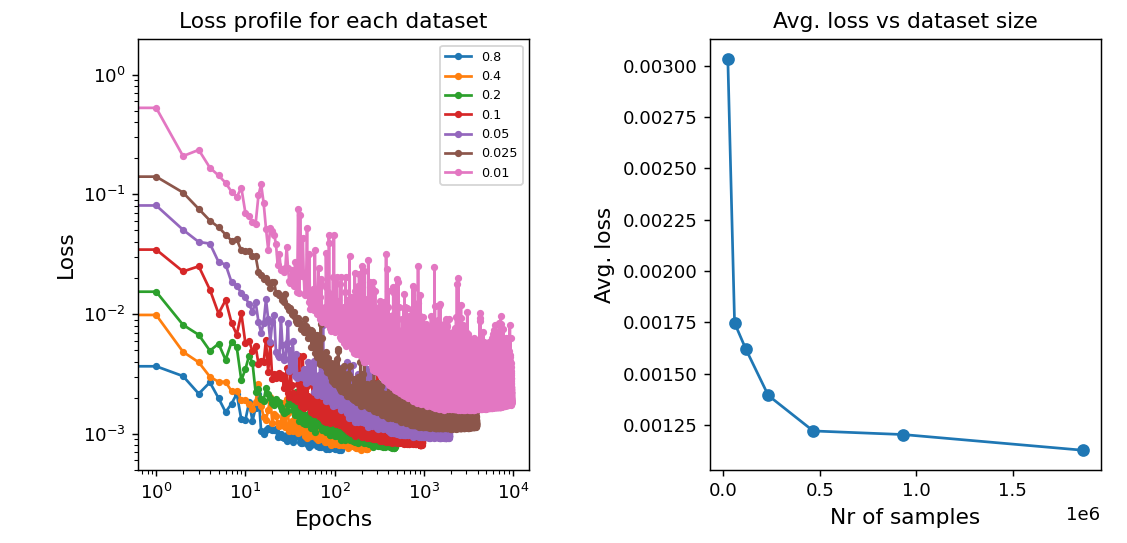

In [58]:
print("Time spend in training:")
print(*[f"{d:2.0f} sec. |" for d in datasize_dict['time']])

smth_costs = [np.mean(list(c)[:-20]) for c in datasize_dict["costs"]]
print(*[f"size {d}: cost {s:1.4f} |" for d,s in zip(datasize_dict['size_data'],smth_costs)])

plt.figure()
plt.subplot(121)
plt.title("Loss profile for each dataset")
for cost in datasize_dict["costs"]:
    plt.plot(cost,".-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.legend(fracs)
plt.subplot(122)
plt.title("Avg. loss vs dataset size")
plt.plot(datasize_dict["size_data"],smth_costs,"-o")
plt.xlabel("Nr of samples",fontsize=12)
plt.ylabel("Avg. loss",fontsize=12)
plt.tight_layout()
plt.show()

From the above plots, we observe that **very large datasets "saturate" the loss**. This means that there is little additional information in a large subset of data since the function is already well represented by a dataset of a certain size (if and only if there is good coverage of the relevant domain of the function). In addition, we also observe **overfitting when the dataset is too small**, meaning that the data does not represent the function well enough and the noise in the data starts overtaking. 

## Batch Size and Learning Rate

### Batch Size
We now turn our attention to the learning rate and the batch size and study the performance of the base model (full dataset) depending on these two hyperparameters. 
We start by training several models, each with different batch size, and plot their performance. Notice that when we reduce the batch size, the number of updates per epoch increase accordingly. Consequently, the training time increases. Although the number of updates per epoch increases by a factor of 4, training time scales better. Here, we disregard the increase in training time and keep the number of epochs constant. However, the decision for/against a particular batch size will take time and performance into consideration. 

In [82]:
configs_bs = load_configs("./configs_explore_training.json")
print(f"configs: {configs_bs}")
batch_sizes = [2048,512,128,64] #[2048,1024,512,128,32]
print(f"Batch sizes used {batch_sizes}")

configs: {'rootdir': '../tmp/DUMP', 'data': {'location': '../tmp/example_data/example_1/processed_data.npz', 'steps': 3, 'batch_size': False, 'amplification': 28.5}, 'model': {'hidden_layers': [90, 90, 90, 90, 90], 'in_features': 7, 'out_features': 1, 'activation': 'ReLU'}, 'training': {'nr_epochs': 120, 'learning_rate': 0.0004, 'save_interval': False, 'optimiser': 'torch.optim.adam'}}
Batch sizes used [2048, 512, 128, 64]


In [83]:
plt.ioff()
results_batch = batchsize_swipe(batch_sizes, FCNN, configs_bs)
plt.ion()

results_batch["configs"] = configs_bs
f = open("results_batch.pkl","wb")
pickle.dump(results_batch,f)
f.close()

Data loading from: 
../tmp/example_data/example_1/processed_data.npz
Saving runs in ../tmp/DUMP


Val. Err.:0.0008 | #batches: 36410 #batch size 64: 100%|█| 4/4 [6:22:37<00:00, 5


Time spend in training:
3148 sec. | 3368 sec. | 6220 sec. | 10220 sec. |
cost 0.0025 | cost 0.0014 | cost 0.0010 | cost 0.0009 |


<IPython.core.display.Javascript object>


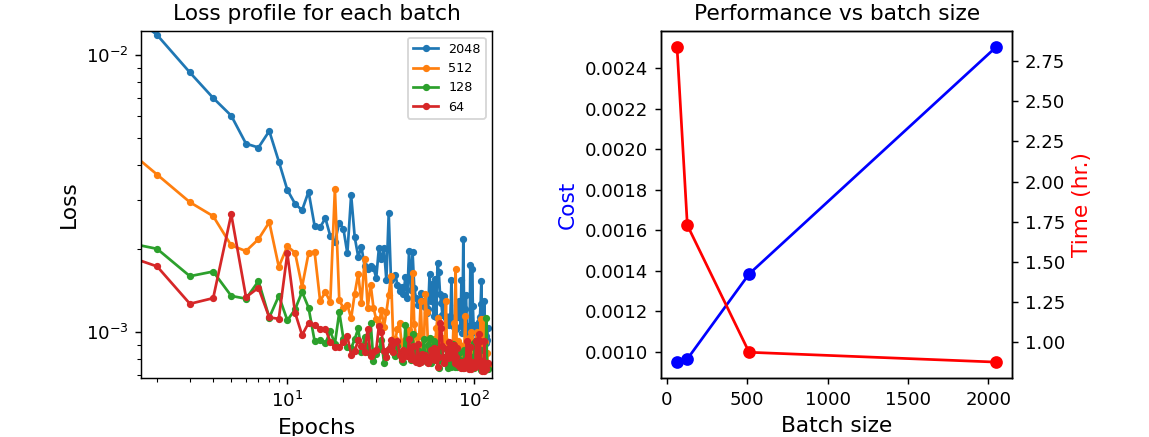

In [87]:
print("Time spend in training:")
print(*[f"{d:2.0f} sec. |" for d in results_batch['training_time']])
smth_costs_bs = [np.mean(list(c)[:-20]) for c in results_batch["costs"]]
print(*[f"cost {s:1.4f} |" for s in smth_costs_bs])
plt.figure()
plt.subplot(121)
plt.title("Loss profile for each batch")
for cost in results_batch["costs"]:
    plt.plot(cost,".-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.legend(batch_sizes)
ax1 = plt.subplot(122)
plt.title("Performance vs batch size")
ax1.plot(batch_sizes,smth_costs_bs,"-o",color="blue")
ax1.set_ylabel("Cost",color="blue",fontsize=12)
ax2 = ax1.twinx()
ax2.plot(batch_sizes,results_batch['training_time']/3600,"-o",color="red")
ax2.set_ylabel("Time (hr.)",color="red",fontsize=12)
ax1.set_xlabel("Batch size",fontsize=12)
plt.tight_layout()
plt.show()

Here, we observe that the batch size has some influence on the performance, but not significantly. Thus, we expect that the increase in training time for small batches is not justified. However, for a fixed number of epochs, a very large batch size is detrimental to the performance and should be avoided. This is because the number of updates per epoch is smaller and, thus, convergence is slower. Could we ameliorate the slow convergence of large batch sizes using a larger learning rate? 

### Learning Rate
Before answering this, let us study the effect of the learning rate on the performance given a fixed budget of 400 epochs. Naturally, we expect a slower convergence for smaller learning rates, but how large should we choose the learning rate in our case? A large value could destabilize learning, so what is the best learning rate? We study this for a batch size of 512. Notice that we expect only a significant effect in the extreme values of the learning rate since we are using ADAM. 

In [111]:
configs_lr = load_configs("./configs_explore_training.json")
print(f"configs: {configs_lr}")
rates = [0.01,0.001,0.0005,0.0001,0.00003]
print(f"Rates used: {rates}")

configs: {'rootdir': '../tmp/DUMP', 'data': {'location': '../tmp/example_data/example_1/processed_data.npz', 'steps': 3, 'batch_size': 512, 'amplification': 28.5}, 'model': {'hidden_layers': [90, 90, 90, 90, 90], 'in_features': 7, 'out_features': 1, 'activation': 'ReLU'}, 'training': {'nr_epochs': 400, 'learning_rate': False, 'save_interval': False, 'optimiser': 'torch.optim.adam'}}
Rates used: [0.01, 0.001, 0.0005, 0.0001, 3e-05]


In [112]:
plt.ioff()
results_lr = lr_swipe(rates, FCNN, configs_lr)
plt.ion()

results_lr["configs"] = configs_lr
f = open("results_lr.pkl","wb")
pickle.dump(results_lr,f)
f.close()

Data loading from: 
../tmp/example_data/example_1/processed_data.npz
Saving runs in ../tmp/DUMP


Val. Error:0.0010 | lr: 3e-05: 100%|████████| 5/5 [14:54:57<00:00, 10739.55s/it]


<IPython.core.display.Javascript object>


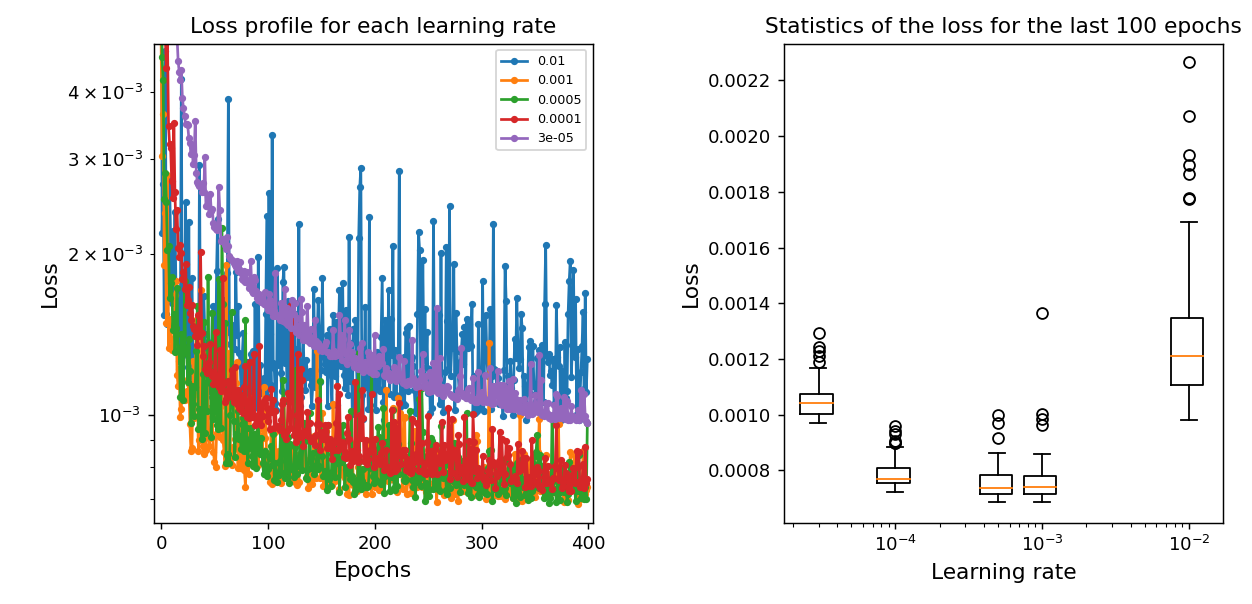

In [115]:
plt.figure()
plt.subplot(121)
plt.title("Loss profile for each learning rate")
for cost in results_lr["costs"]:
    plt.plot(cost,".-")
plt.legend(rates)
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.subplot(122)
last_eps = 100
plt.title(f"Statistics of the loss for the last {last_eps} epochs")
plt.boxplot(np.asarray([c for c in results_lr["costs"]] )[:,-last_eps:].T,positions=rates,widths=np.asarray(rates)*0.5)
plt.xscale("log")
plt.xlabel("Learning rate",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.tight_layout()
plt.show()

We see that we can use learning rates larger than 0.0001 and up to 0.001 with a convergence of about 200 epochs. The validation error is around 0.75 nA (MSE of 0.0007). A learning rate of 0.1 hinders learning completely (not shown) and a learning rate of 0.01 has too much variance, s.t. the loss converges fast, but to a higher value. As expected, very small learning rates will slow down convergence.
Notice that we used a batch size of 512. Compared to the previous experiment where this batch size gives an MSE 2x larger, we were able to improve performance with longer training. Here, large batches will require more epochs since the number of updates is smaller, e.g. a batch of 2048 reduces performance quite significantly, especially for small learning rates. On the other size, the training time increases with the batch size: a batch size of 64 took around 1 hr longer than a batch size of 128 (ca 1 hr 45 min) without improving the final performance significantly. Finally, we can obtain a similar performance with a batch size of 512 when we train for 200 epochs. This will take roughly 1 hr 30 min.  

### Simultaneous exploration of batch size and learning rate 
From the above observations, there seems to be an **optimal combination of batch size and learning rate allowing for a low number of epochs/short training time**. A larger learning rate combined with a large batch size can have the benefit of very short training times. Optimizing this will take a very long time since we also have to find a suitable number of epochs. 
Here, I will only explore the effect of changing the batch size and the learning rate. To avoid a very long exploration, we keep the batch size relatively large, and for each value explore several learning rates (limiting ourselves to values that converge within 200 epochs). We average the cost over the last 15 epochs.
Can we beat the performance of small batch sizes in a shorter time?

In [116]:
configs_bslr = load_configs("./configs_explore_training.json")
print(f"configs: {configs_bslr}")

bs = [2048, 1024, 512, 256] #[2048,512,128,64]
lr = [0.01, 0.001, 0.0003]#, 0.0005, 0.0003]

print(f"Rates used: {lr}")
print(f"Batch sizes used: {bs}")

configs: {'rootdir': '../tmp/DUMP', 'data': {'location': '../tmp/example_data/example_1/processed_data.npz', 'steps': 3, 'batch_size': False, 'amplification': 28.5}, 'model': {'hidden_layers': [90, 90, 90, 90, 90], 'in_features': 7, 'out_features': 1, 'activation': 'ReLU'}, 'training': {'nr_epochs': 200, 'learning_rate': False, 'save_interval': False, 'optimiser': 'torch.optim.adam'}}
Rates used: [0.01, 0.001, 0.0003]
Batch sizes used: [2048, 1024, 512, 256]


In [117]:
plt.ioff()
results_bslr = bslr_swipe(bs,lr, FCNN, configs_bslr, end_epochs=15)
plt.ion()

results_bslr["configs"] = configs_bslr
f = open("results_bslr.pkl","wb")
pickle.dump(results_bslr,f)
f.close()

Data loading from: 
../tmp/example_data/example_1/processed_data.npz
Saving runs in ../tmp/DUMP


Val. Errors:['0.0010', '0.0008', '0.0008', '0.0008'] | lr: 0.0003: 100%|█| 3/3 [


Best peformance:  0.00076
Difference of scaled costs (0 is minimum) 
 [[0.474 0.344 0.631 0.976]
 [0.058 0.094 0.035 0.   ]
 [0.333 0.092 0.113 0.005]]
Training time in hours 
 [1.38098245 1.38819622 1.50168159 1.96132524]


<IPython.core.display.Javascript object>


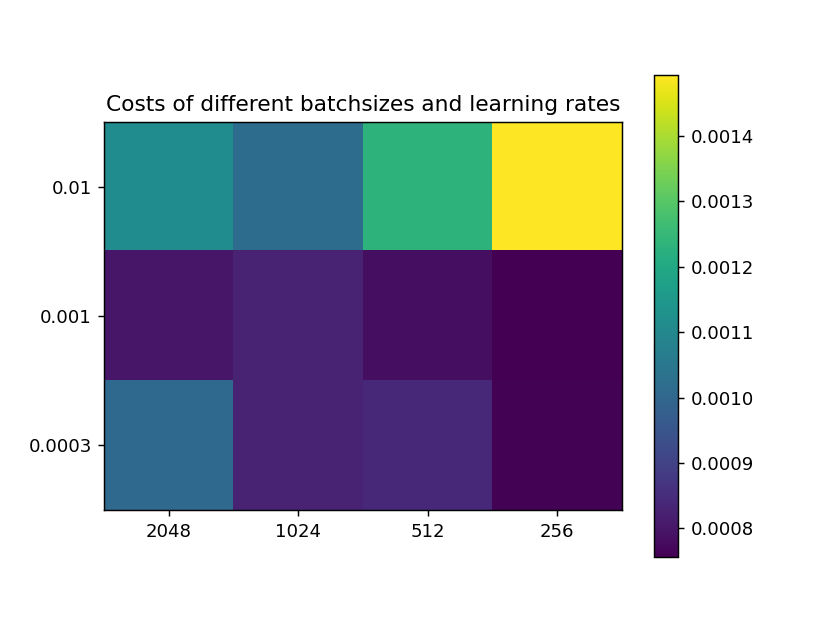

In [118]:
minbslr = np.min(results_bslr['costs_grid'])
print(f"Best peformance: {minbslr: 1.5f}")
print(f"Difference of scaled costs (0 is minimum) \n {np.around(results_bslr['costs_grid']/minbslr-1.0,3)}")
print(f"Training time in hours \n {np.mean(results_bslr['training_time']/3600,axis=0)}")

plt.figure()
plt.title("Costs of different batchsizes and learning rates")
plt.imshow(results_bslr["costs_grid"])
plt.colorbar()
ax = plt.gca()
ax.set_xticks(range(len(bs)))
ax.set_xticklabels(bs)
ax.set_yticks(range(len(lr)))
ax.set_yticklabels(lr)
plt.show()


In [1]:
# print(results_bslr.keys())

# # TODO: Plot boxplots for each bs
# print(np.asarray([c for c in lrc]).shape)
# plt.figure()
# for n,lrc in enumerate(results_bslr["costs_profiles"]):
#     plt.subplot(2,2,n+1)
#     plt.title(f"lr = {lr[n]}")
# #     plt.plot(np.asarray(lrc).T)
#     plt.boxplot(np.asarray([c for c in lrc])[:,-10:].T,positions=bs,widths=np.asarray(bs)*0.2)
# #     plt.yscale("log")
# #     plt.xscale("log")
# #     plt.legend(bs)
# plt.tight_layout()
# plt.show()

From the above results, we notice that **small batches and large learning rate results in poorer performance** than larger batch size and learning (first row in the image). Although large batches can be used, the training time is not significantly reduced. A batch size of 256 with a small learning rate of ca. 0.001 needs ca. 35 min longer training, resulting in a performance improvement of around 6% compared to a very large batch size with the same learning rate (middle row in the image). 
However, given a small batch size (smaller than 256), the performance will not justify the training time. As a sanity check, we run a few such examples. The best (averaged) performance, in this case, is 0.00077 for a batch size of 64 and a learning rate of 0.0003, and needed 2 hrs 45 min (vs 0.00076 for a batch size of 256, a learning rate of 0.001, and with 2 hrs of training).

In [107]:
configs_bslrsmall = load_configs("./configs_explore_training.json")
lr=[0.0003,0.00005,0.00001]
bs=[128,64,32]

print(f"configs: {configs_bslr}")
print(f"Rates used: {lr}")
print(f"Batch sizes used: {bs}")

configs: {'rootdir': '../tmp/DUMP', 'data': {'location': '../tmp/example_data/example_1/processed_data.npz', 'steps': 3, 'batch_size': 1024, 'amplification': 28.5}, 'model': {'hidden_layers': [90, 90, 90, 90, 90], 'in_features': 7, 'out_features': 1, 'activation': 'ReLU'}, 'training': {'nr_epochs': 20, 'learning_rate': 0.001, 'save_interval': False, 'optimiser': 'torch.optim.adam', 'save_dir': '../tmp/DUMP/lrbs_swipe/lr_0.001/bs_1024'}}
Rates used: [0.0003, 5e-05, 1e-05]
Batch sizes used: [128, 64, 32]


In [28]:
plt.ioff()
results_bslrsmall = bslr_swipe(bs,lr, FCNN, configs_bslrsmall, end_epochs=20)
plt.ion()

results_bslrsmall["configs"] = configs_bslrsmall
f = open("results_bslrsmall.pkl","wb")
pickle.dump(results_bslrsmall,f)
f.close()

Data loading from: 
../tmp/example_data/example_1/processed_data.npz
Metadata :
 dict_keys(['save_directory', 'data_name', 'processor', 'input_data', 'clipping_value'])
--> Shape of INPUTS: (2912777, 7)
--> Shape of OUTPUTS: (2912777,)
Saving runs in ../tmp/results/notebooks/FCNN/bslr_small


Val. Errors:['0.001453', '0.001092', '0.000993'] | lr: 1e-05: 100%|█████████████████████████████████████| 3/3 [28:11:27<00:00, 33829.33s/it]

Best peformance: 0.0007662035728571937


Difference of scaled costs (0 is minimum) 
 [[ 7.41893238e-03 -2.21061900e-02 -2.27448571e-04]
 [ 9.44200335e-02  4.62257156e-02 -6.27736216e-03]
 [ 8.54720697e-01  3.94159965e-01  2.67662309e-01]]


<IPython.core.display.Javascript object>


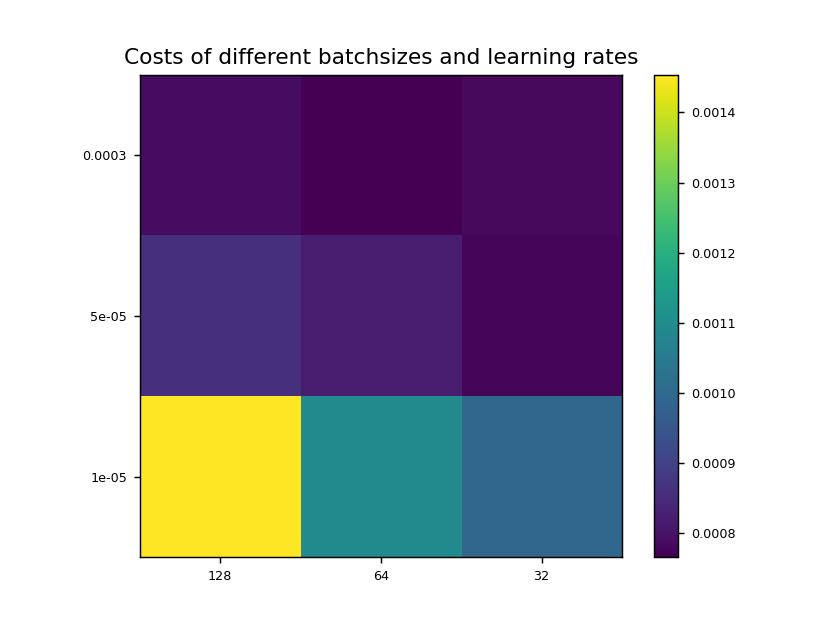

Training time in hours 
 [1.64418359 2.74403039 5.00850713]


In [33]:
best_small = np.min(results_bslrsmall['costs_grid'])
print(f"Best peformance: {best_small}")
print(f"Difference of scaled costs (0 is minimum) \n {results_bslrsmall['costs_grid']/minbslr-1.0}")
print(f"Training time in hours \n {np.mean(results_bslrsmall['training_time']/3600,axis=0)}")

plt.figure()
plt.title("Costs of different batchsizes and learning rates")
plt.imshow(results_bslrsmall["costs_grid"])
plt.colorbar()
ax = plt.gca()
ax.set_xticks(range(len(bs)))
ax.set_xticklabels(bs)
ax.set_yticks(range(len(lr)))
ax.set_yticklabels(lr)
plt.show()



<IPython.core.display.Javascript object>


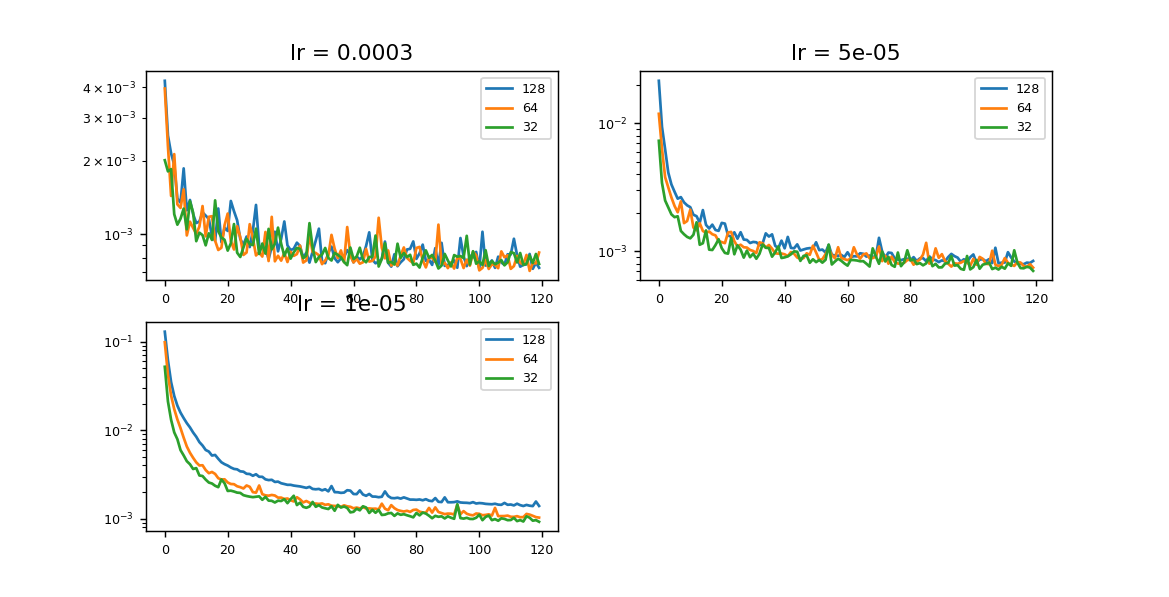

In [34]:
plt.figure()
for n,lrc in enumerate(results_bslrsmall["costs_profiles"]):
    plt.subplot(2,2,n+1)
    plt.title(f"lr = {lr[n]}")
    plt.plot(np.asarray(lrc).T)
    plt.yscale("log")
    plt.legend(bs)
plt.show()

## Conclusion
Specifically for DNPUs, we only need about 20-50% of the data points sampled to obtain similar performance. Notice that this *does not* necessarily translate to faster training because the number of updates remained equal. Nevertheless, it does mean that there is some **redundancy in the data and we can reduce the time spent in data acquisition**. I do not recommend that the sampling time is reduced before breaking the correlation of the inputs by randomizing the phase of the periodic input signals. **->> SUGGESTION for DNPUs: Randomize the phase of the input during the data acquisition after one or few sampling batches.** This will cover the input space faster and increase the data quality s.t. less data is needed. 
We conclude that small batches do not improve the model significantly and that *a wide range of configurations give good results*. Nevertheless, **we should use a batch size of 256 with a small learning rate of ca. $\eta=4\times10^{-4}\dots0.001$. This configuration will allow fine-tuning the model while keeping the training time short**.  
An interesting question remains: How precise must be the model to predict functionality? This must be studied by analysing the impact of the model error and the fail rate of functionality prediction (in terms of false positives and false negatives). Understanding this relation will allow optimizing the training time further.  